### Modelling Spread of Diseases using Agent Based Modelling

In this project, the aim is to model the spread of diseases across individuals over time, accounting for the movement of individuals across a grid space. The set up is as follows:

Agent: Individual (location, infected, transmission rate, recovery rate, vacc status) The transmission rate dependent on vacc status and recovery rate is dependent on the strength of the disease, which factors their values up or down given strength, 
Potential other things to add: immunity after infection.

Disease (Strength) and also another factor of minimum recovery timestep, which is the minimum amount of time steps before any recovery (using the recovery rate) can be taken.

Environment: Consists of 10 different nodes/locations, where each node is has a 50x50 grid space, where agents can be at (agent.location)

Location Rules:

1. An agent can choose one of three choices, stay where they are, move to another grid space within the node, or move to another grid space at another node
2. Agents can move freely from one node to any other at one timestep, no hinderances besides capacity in 3.
3. If the grid space is already occupied by an agent, randomly select another space in the node, otherwise if all taken, randomly select another node and grid space.

Infection Rules:

1. An agent can be infected at a timestep if they are within a 5x5 grid space of an infected individual, dependent on their transmission rate.
2. The probability of the agent recovering from the infection depends on the recovery rate.
3. An individual that is infected has should not move from their location

Parameters to collect:

- Percentage of infected at each timestep for each node
- Percentage of infected by vacc status
- Average infections per population in node

Things to consider:
- Deaths (Death Rate Probability - Dependent on vaccs, and also immunity)
- Try one city first, if works then expand. 
- 3 parameters to determine movement of individual across grid space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import correlate2d

cmap = ListedColormap(['white', 'grey', 'red', 'blue'])
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

## Creating the Agent Class

In [103]:
#hyperparameters to tune
infection_rate = 0.3 # percentage of people infected
vacc_rate = 0.5 # percentage of people vaccinated
n_humans = 500
grid_space = 50
n_nodes = 10
steps = 100
scan_space = 3
movement_prob = [0.1, 0.5, 0.4]
min_infect_days = 2
multiplier_factor = 1.2 
vaccine_multiplier = 0.5 # can be used to increase or decrease the effectiveness of the vaccine
immunity_multiplier = 0.5 # can be used to increase or decrease the effectiveness of the vaccine
vaccine_randomness = 0.05 # can be used to increase or decrease the randomness of the vaccine
immunity_randomness = 0.05 # can be used to increase or decrease the randomness of the vaccine

In [163]:
class Human():
    def __init__(self):
        self.infected = np.random.random() < infection_rate
        self.transmission_rate = np.random.random() # getting infected chance
        self.recovery_rate = np.random.random() 
        self.vaccine = np.random.random() < vacc_rate
        self.infected_time = 0
        self.immunity = False # if infected and recovered, then immune = True

    '''Choose a new location to move to based on random probability'''
    def choose_newlocation(self):
        if self.infected: # stay at location
            self.decision = 0
        else: # make choice to move to a new location or stay
            # using a dirichlet distribution, which is distribution over vectors of probabilities that sum to 1 (2 for now, will up to 3 when create cities)
            random_moveto = np.random.dirichlet(np.ones(2), size=1)
            self.decision = np.argmax(random_moveto)
        return self.decision
    
    def recovery(self): # run at each step
        chance_recovery = np.random.random() #move down later
        if self.infected:
            if self.infected_time > min_infect_days:
                if self.vaccine:
                    vaccine_multiplier_self = np.random.normal(vaccine_multiplier, vaccine_randomness) # introduce randomness to vaccine for human
                    chance_recovery = chance_recovery * vaccine_multiplier_self
                if self.immunity:
                    immunity_multiplier_self = np.random.normal(immunity_multiplier, immunity_randomness) # introduce randomness to immunity for human
                    chance_recovery = chance_recovery * immunity_multiplier_self
                if chance_recovery < self.recovery_rate: # recovered
                    self.infected = False
                    self.immunity = True
                    self.infected_time = 0
                else:  # not recovered
                    self.infected_time += 1
            else:
                self.infected_time += 1
        else:
            pass
        return self.infected, self.immunity, self.infected_time, chance_recovery
    
    def infect(self, n_infected): # run at each step
        chance_infection = np.random.random() #move down later, just for checking
        # account for more infected people, more chance of infection
        adjusted_chance_infection = chance_infection * (multiplier_factor ** (n_infected - 1))
        adjusted_chance_infection = min(adjusted_chance_infection, 1)
        if self.infected:
            pass
        else: # not infected
            if n_infected > 0:
                if self.vaccine:
                    vaccine_multiplier_self = np.random.normal(vaccine_multiplier, vaccine_randomness)
                    adjusted_chance_infection = adjusted_chance_infection * vaccine_multiplier_self
                if self.immunity:
                    immunity_multiplier_self = np.random.normal(immunity_multiplier, immunity_randomness)
                    adjusted_chance_infection = adjusted_chance_infection * immunity_multiplier_self
                if adjusted_chance_infection > self.transmission_rate:
                    self.infected = True
                    self.infected_time = 0
        return n_infected, self.infected, self.transmission_rate, adjusted_chance_infection, chance_infection

## Creating the Environment Grid Space of Suburb

This is just for one city, another class City (to contain 10 Suburbs)

In [74]:
class Suburb():
    # create a 50x50 grid space
    def __init__(self):
        self.grid = np.zeros((grid_space,grid_space))
        self.humans = []

    '''Populates the grid space with humans, initial configuration'''
    def populate(self, n_humans):
        # randomly place humans around in the grid, 1 person per grid space
        self.humans = [Human() for i in range(n_humans)]
        for human in self.humans:
            x = np.random.randint(0,grid_space)
            y = np.random.randint(0,grid_space)
            # check if the grid space is already occupied
            while self.grid[x,y] != 0:
                x = np.random.randint(0,grid_space)
                y = np.random.randint(0,grid_space)
            if human.infected:
                self.grid[x,y] = 2 # if infected
            else:
                self.grid[x,y] = 1 # if not infected
            human.location = (x,y) # save location of human
    
    '''checks the grid space around each human to find number of infected people''' 
    def scan(self, human):
        # find neighbours of human
        x, y = human.location[0], human.location[1]
        #neighbours = []
        # set boundary constraints
        x_min = max(0, x-scan_space)
        x_max = min(grid_space-1, x+scan_space)
        y_min = max(0, y-scan_space)
        y_max = min(grid_space-1, y+scan_space)
        neighbours = self.grid[x_min:x_max+1, y_min:y_max+1]
        infected = np.sum(neighbours == 2)
        if human.infected:
            return(infected - 1) #number of infected humans around the human
        else:
            return(infected) #number of infected humans around the human
                

        

In [164]:
sub = Suburb()
sub.populate(n_humans) # number of humans in the city cannot be greater than the number of grid spaces (50x50)

In [165]:
# test case of whether the new location is chosen well. 
for i in sub.humans[5:10]:
    print(i.infected, i.location)
    check= i.choose_newlocation()
    print('Check Movment: ', check)
    print('Infected Neighbours: ', sub.scan(i))
    print('If Infected: ', i.infected)
    print('Immunity: ', i.immunity)
    print('Vaccine: ', i.vaccine)
    print('Inf Time: ', i.infected_time)
    print('Recovery and trans rate: ', i.recovery_rate, i.transmission_rate)
    print('---------------------------')

True (22, 36)
Check Movment:  0
Infected Neighbours:  3
If Infected:  True
Immunity:  False
Vaccine:  True
Inf Time:  0
Recovery and trans rate:  0.9544606963498936 0.1023497388943001
---------------------------
True (9, 28)
Check Movment:  0
Infected Neighbours:  5
If Infected:  True
Immunity:  False
Vaccine:  True
Inf Time:  0
Recovery and trans rate:  0.8119929085466274 0.22673563316888368
---------------------------
False (2, 6)
Check Movment:  1
Infected Neighbours:  2
If Infected:  False
Immunity:  False
Vaccine:  False
Inf Time:  0
Recovery and trans rate:  0.8680822380696245 0.6374088771106671
---------------------------
True (26, 45)
Check Movment:  0
Infected Neighbours:  0
If Infected:  True
Immunity:  False
Vaccine:  True
Inf Time:  0
Recovery and trans rate:  0.612325532964018 0.6794898250887084
---------------------------
True (10, 40)
Check Movment:  0
Infected Neighbours:  2
If Infected:  True
Immunity:  False
Vaccine:  False
Inf Time:  0
Recovery and trans rate:  0.282

In [166]:
for i in sub.humans[10:20]:
    infected, immunity, infected_time, chance_recovery = i.recovery()
    print('Infected: ', infected)
    print('Immunity: ', immunity)
    print('Inf Time: ', infected_time)
    print('Chance Recovery: ', chance_recovery)

Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.904789445935067
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.3083464972791843
Infected:  True
Immunity:  False
Inf Time:  1
Chance Recovery:  0.7245223898194668
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.7571203718028463
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.448223557888795
Infected:  True
Immunity:  False
Inf Time:  1
Chance Recovery:  0.21073451023921352
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.8355167378494194
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.4384529154271394
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.40417161788066913
Infected:  False
Immunity:  False
Inf Time:  0
Chance Recovery:  0.8069586895160286


In [167]:
# test the infect function
for i in sub.humans[10:20]:
    n_inf, infected, transmission_rate, adjusted_chance_infection, chance_infection = i.infect(sub.scan(i))
    print('Infected: ', infected)
    print('Transmission Rate: ', transmission_rate)
    print('Adjusted Chance Infection: ', adjusted_chance_infection)
    print('Chance Infection: ', chance_infection)
    print('Number Infected: ', n_inf)
    print('---------------------------')

Infected:  False
Transmission Rate:  0.6419572563914935
Adjusted Chance Infection:  0.5046322929790036
Chance Infection:  0.7243905011841429
Number Infected:  3
---------------------------
Infected:  True
Transmission Rate:  0.3684506812966958
Adjusted Chance Infection:  0.9179305534798659
Chance Infection:  0.7649421278998882
Number Infected:  2
---------------------------
Infected:  True
Transmission Rate:  0.05999551377020551
Adjusted Chance Infection:  0.9527470413686482
Chance Infection:  0.661629889839339
Number Infected:  3
---------------------------
Infected:  False
Transmission Rate:  0.9445229996324008
Adjusted Chance Infection:  0.5856015140478157
Chance Infection:  0.9743399637071546
Number Infected:  1
---------------------------
Infected:  True
Transmission Rate:  0.7260078973756361
Adjusted Chance Infection:  0.8583958772327817
Chance Infection:  0.7153298976939847
Number Infected:  2
---------------------------
Infected:  True
Transmission Rate:  0.33146458928335465
Ad

In [15]:
# randomly select 5 humans to test:
for i in range(5):
    human = sub.humans[np.random.randint(0, len(sub.humans))]
    print(human.location)
    print(sub.scan(human))

(39, 38)
1
(29, 33)
1
(34, 5)
0
(24, 24)
0
(17, 40)
1


(8, 25)
0


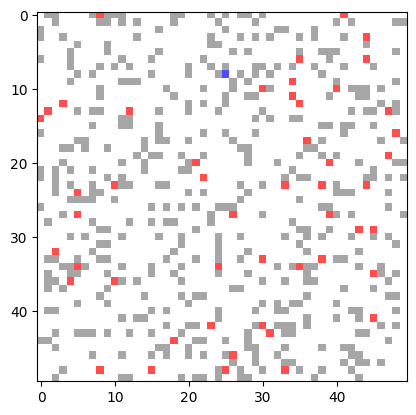

In [29]:
# check if the neighbours are being found correctly
def check_grid_infect():
    human = sub.humans[np.random.randint(0, len(sub.humans))]
    hx, hy = human.location[0], human.location[1]
    print(human.location)
    print(sub.scan(human))
    init = sub.grid[hx,hy] 
    sub.grid[hx,hy] = 4
    plt.imshow(sub.grid, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.7)
    plt.show()
    sub.grid[hx,hy] = init

check_grid_infect()

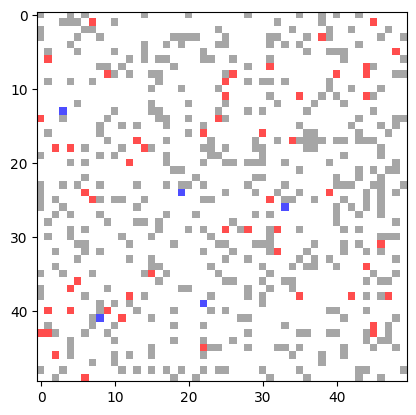

In [372]:

plt.imshow(sub.grid, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.7)
plt.show()

In [218]:
# check if the number of infected people is around 10% of the population
np.sum(v.grid == 2)/n_humans

0.094

In [227]:
grid = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

# Define a 5x5 window (kernel) for correlation
kernel = np.ones((scan_space, scan_space))

result = correlate2d(v.grid, kernel, mode='same', boundary='wrap')
result

array([[2., 2., 4., ..., 5., 4., 4.],
       [6., 5., 6., ..., 3., 5., 6.],
       [6., 5., 6., ..., 3., 4., 5.],
       ...,
       [4., 4., 5., ..., 5., 4., 5.],
       [3., 2., 4., ..., 5., 4., 4.],
       [2., 2., 4., ..., 5., 4., 4.]])